### creating a fully connected network


In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self,N_input ,N_output , N_Hidden ,N_layers):
        super(Net,self).__init__()
        activation = nn.Tanh()
        self.f1 = nn.Sequential(*[nn.Linear(N_input ,N_Hidden) , activation])
        self.f2 = nn.Sequential(*[nn.Sequential(*[nn.Linear(N_Hidden , N_Hidden), activation]) for _ in range(N_layers)])
        self.f3 = nn.Sequential(*[nn.Linear(N_Hidden,N_output)])
    def forward(self , x) : 
        x = self.f1(x)
        x = self.f2(x)
        x = self.f3(x)
        return x

### Definig The Losses

In [6]:
import torch as tf
import numpy as np
import time





def ui(x, y , pinn):
    grid = tf.cat((x, y), dim=1)
    return pinn(grid)

# defining the pde 
def f(x, y ,pinn):
    x.requires_grad_(True)
    y.requires_grad_(True)
    u = ui(x, y ,pinn)
    
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    u_y = torch.autograd.grad(u, y, torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True,retain_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, torch.ones_like(u_y), create_graph=True,retain_graph=True)[0]
    return u_xx + u_yy 

def f_finie_diff(x, y ,pinn):

    u = ui(x, y ,pinn)

    u_x = (u[:, 2:] - u[:, :-2]) / (2 * dx)
    u_y = (u[2:, :] - u[:-2, :]) / (2 * dy)
    u_xx = (u[:, 2:] - 2 * u[:, 1:-1] + u[:, :-2]) / dx**2
    u_yy = (u[2:, :] - 2 * u[1:-1, :] + u[:-2, :]) / dy**2
    return u_xx + u_yy

def f2(x, y ,pinn):
    
    f_pred = f(x, y ,pinn)
    r = (f_pred - tf.exp(-10 * (x**2 + y**2))*(-20)*(1-20*x**2) -tf.exp(-10 * (x**2 + y**2))*(-20)*(1-20*y**2) )
    return torch.abs(r)
def adaptive_collocation_points(x, y, model, k=1.0):
   
    residuals = f2(x, y, model)
    
    p = residuals**k / torch.sum(residuals**k)
    indices = torch.multinomial(p.flatten(), num_samples=p.numel(), replacement=True)
    x_new = x.flatten()[indices].unsqueeze(1)
    y_new = y.flatten()[indices].unsqueeze(1)

    #x_new += (torch.rand_like(x_new) - 0.5) * 0.05
    #y_new += (torch.rand_like(y_new) - 0.5) * 0.05
    return x_new, y_new
#initial and boundary conditions losses
def loss_boundary_1(x , pinn):
    u_boundary =  torch.exp(-10*(x**2+9))

    return tf.mean((ui(x , -3*torch.ones_like(x),pinn) - u_boundary)**2)
def loss_boundary_2(x,pinn):
    u_boundary =  torch.exp(-10*(x**2+9))

    return tf.mean((ui(x , 3*torch.ones_like(x),pinn) - u_boundary)**2)

def loss_boundary_3(y,pinn):
    u_boundary =  torch.exp(-10*(y**2+9))
  
    return tf.mean((ui( 3*torch.ones_like(y),y,pinn) - u_boundary)**2)

def loss_boundary_4(y ,pinn):
    u_boundary = torch.exp(-10*(y**2+9))
  
    return tf.mean((ui( -3*torch.ones_like(y),y,pinn) - u_boundary)**2)
def check_for_interrupt():
    try:
        time.sleep(0)
    except KeyboardInterrupt:
        print("Interrupted!")
        raise KeyboardInterrupt

# pde loss
def loss_fn(x, y ,pinn):
    

    
    f_pred = f(x, y ,pinn)
    return torch.mean((f_pred - tf.exp(-10 * (x**2 + y**2))*(-20)*(1-20*x**2) -tf.exp(-10 * (x**2 + y**2))*(-20)*(1-20*y**2) )**2) 


def loss_fn2(x, y ,pinn):

    
    f_pred = f(x, y ,pinn) 
    return torch.mean((f_pred - tf.exp(-10 * (x**2 + y**2))*(-20)*(1-20*x**2) -tf.exp(-10 * (x**2 + y**2))*(-20)*(1-20*y**2) )**2)

def create_grid(num_points):
    x = np.linspace(-1, 1, num_points)
    y = np.linspace(-1, 1, num_points)
    x_grid, y_grid = np.meshgrid(x, y)
    x_grid = x_grid.flatten()
    y_grid = y_grid.flatten()
    return x_grid, y_grid

# Step 2: Randomly select points from the grid
def select_random_points(x_grid, y_grid, num_samples):
    indices = np.random.choice(len(x_grid), num_samples, replace=False)
    selected_x = x_grid[indices]
    selected_y = y_grid[indices]
    return selected_x, selected_y

import numpy as np
import matplotlib.pyplot as plt
def u_exact(x , y):
    return np.exp(-10*(x**2 + y**2))*100




## Adaptive Loss and weights

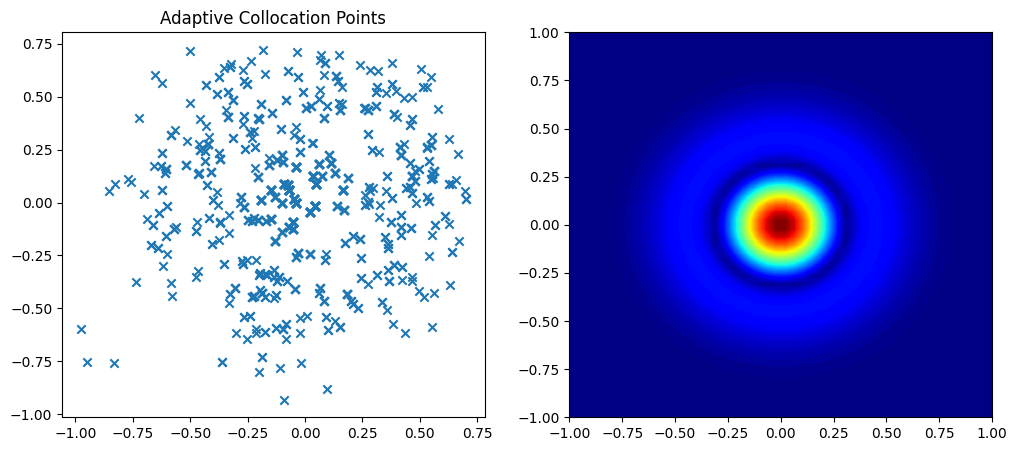

Epoch 0, Loss 11.94708251953125, mse : 560.161376953125,l2_error: 4360.70166015625


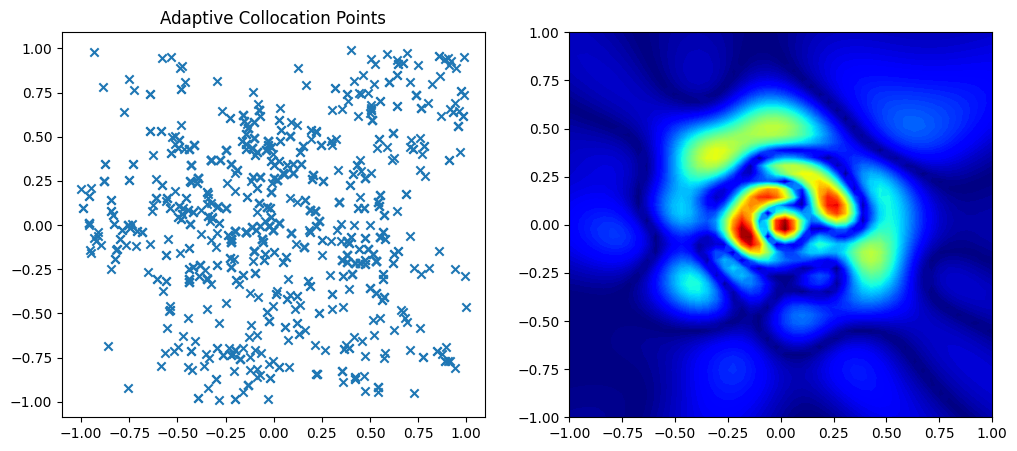

In [9]:

device = torch.device( "cpu")
pinn2 = Net(2, 1, 50, 4).to(device)
x = torch.linspace(-1, 1, 50).to(device)
y = torch.linspace(-1, 1, 50).to(device)

x, y = torch.meshgrid(x, y)
np.random.seed(0)

# random points between -1 and 1
x_adaptive, y_adaptive = create_grid(3000)

indices = torch.randint(0, 100, (1000, 2))

MSE = []
L2_ERROR = []
LOSS = []
W_i =[]
W_bc = []
W_f = []
x2 ,y2 = select_random_points(x_adaptive, y_adaptive, 1000)
x2, y2 = torch.tensor(x2).unsqueeze(1).float().to(device),torch.tensor(y2).unsqueeze(1).float().to(device)

x2.requires_grad = True
y2.requires_grad = True
    
u_ex = torch.exp(-10*(x**2 + y**2))
u_ex = u_ex.to(device)

weight_bc = torch.tensor(1.0, requires_grad=True)
weight_i = torch.tensor(1.0, requires_grad=True)
weight_f = torch.tensor(1.0, requires_grad=True)
optimizer = torch.optim.Adam([{'params':pinn2.parameters()} ,{'params':[weight_bc, weight_i, weight_f]} ], lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)
for epoch in range(100):

    optimizer.zero_grad()
    loss2 = loss_boundary_1(x.flatten().unsqueeze(1), pinn2)
    loss3 = loss_boundary_2(x.flatten().unsqueeze(1), pinn2)
    loss4 = loss_boundary_3(y.flatten().unsqueeze(1), pinn2)
    loss_for_adaptive_points = loss_fn2(x2, y2, pinn2)
    loss5 = loss_boundary_4(y.flatten().unsqueeze(1), pinn2)
    loss_f = loss_fn(x.flatten().unsqueeze(1), y.flatten().unsqueeze(1), pinn2)

    loss = ((loss_f + loss_for_adaptive_points)*tf.exp(-weight_f) +  (loss3 + loss4)*tf.exp(-weight_bc) + (loss2 + loss5)*tf.exp(-weight_i) + torch.abs(weight_bc)**2 + torch.abs(weight_i)**2 + torch.abs(weight_f)**2)*0.5
    loss.backward(retain_graph=True)
   
    optimizer.step()
    scheduler.step()



    if epoch%50 == 0: 
        
        x2, y2 = adaptive_collocation_points(x2, y2, pinn2, k=1.0)
        risid = f2(x.flatten().unsqueeze(1), y.flatten().unsqueeze(1), pinn2)
        fig, ax = plt.subplots(1, 2, figsize=(12, 5))
        ax[0].scatter(x2.cpu().detach().numpy(), y2.cpu().detach().numpy(),marker='x')
        ax[0].set_title("Adaptive Collocation Points")
        ax[1].contourf(x.cpu().detach().numpy(),y.cpu().detach().numpy(),risid.cpu().detach().numpy().reshape(50,50),levels = 100, cmap='jet')
        #plt.scatter(x2.detach().numpy(), y2.detach().numpy(),marker='x')
        plt.show()
        x2 ,y2 = select_random_points(x_adaptive, y_adaptive, 1000)
        x2, y2 = torch.tensor(x2).unsqueeze(1).float().to(device),torch.tensor(y2).unsqueeze(1).float().to(device)

        x2.requires_grad = True
        y2.requires_grad = True
    
        
    W_i.append(tf.exp(-weight_i).detach().numpy())
    W_bc.append(tf.exp(-weight_bc).detach().numpy())
    W_f.append(tf.exp(-weight_f).detach().numpy())



    






    if epoch%100 == 0:
        u_pred_2 = ui(x.flatten().unsqueeze(1), y.flatten().unsqueeze(1),pinn2)
        u_pred_2 = u_pred_2.reshape(50, 50)
        u_pred_2 = u_pred_2.cpu().detach().numpy()

        MSE.append(torch.mean((u_ex.cpu() - 100*u_pred_2) ** 2))
        LOSS.append(loss.item())
        L2_ERROR.append(torch.linalg.norm((u_ex.cpu() - 100*u_pred_2) ** 2)/torch.linalg.norm((u_ex.cpu() ) ** 2))
        
        print(f'Epoch {epoch}, Loss {loss.item()}, mse : {MSE[-1]},l2_error: {L2_ERROR[-1]}')
        #plt.scatter(x2.detach().numpy(), y2.detach().numpy())
        #plt.show()
            


tensor(0.8037, grad_fn=<ExpBackward0>) tensor(0.8030, grad_fn=<ExpBackward0>) tensor(0.3137, grad_fn=<ExpBackward0>) tensor(88.6016, grad_fn=<MulBackward0>) tensor(0.3292, grad_fn=<MulBackward0>) tensor(0.1796, grad_fn=<MulBackward0>) tensor(0.4177, grad_fn=<MulBackward0>) tensor(0.1095, grad_fn=<MulBackward0>)
tensor(0.0007)


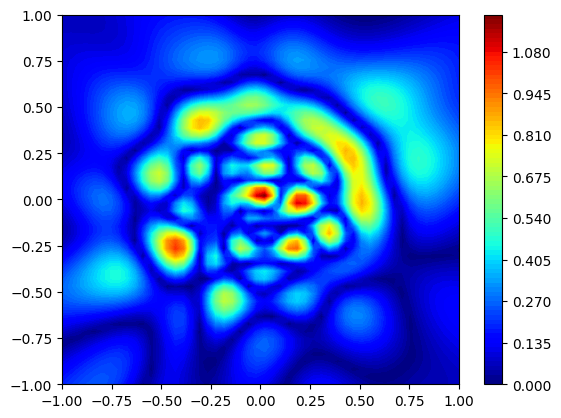

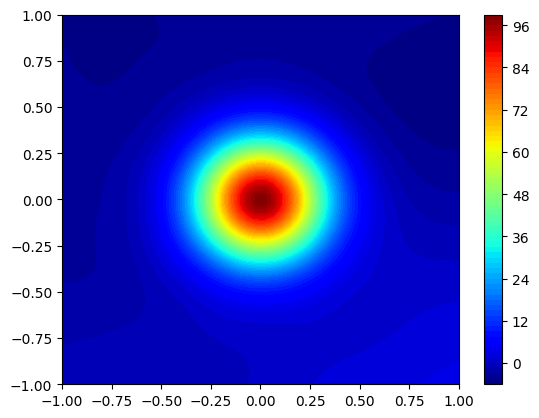

In [10]:
import matplotlib.pyplot as plt
print(tf.exp(-weight_bc),tf.exp(-weight_i),tf.exp(-weight_f) ,loss_f*10**3,loss2*10**3,loss3*10**3,loss4*10**3,loss5*10**3)
x = torch.linspace(1,-1, 50).to(device)
y = torch.linspace(-1, 1, 50).to(device)
x, y = torch.meshgrid(x, y)
risid = f2(x.flatten().unsqueeze(1), y.flatten().unsqueeze(1), pinn2)
u_ex = torch.exp(-10*(x**2 + y**2))

u_pred = ui(x.flatten().unsqueeze(1), y.flatten().unsqueeze(1),pinn2)
#inverse scaling on the boundarys
u_pred = u_pred.reshape(50, 50)
u_pred = u_pred.cpu().detach().numpy()
print(torch.mean((u_ex.cpu() - u_pred) ** 2))
plt.contourf(x.cpu().detach().numpy(), y.cpu().detach().numpy(),risid.cpu().detach().numpy().reshape(50,50),levels =100, cmap='jet')
plt.colorbar()
plt.show()


plt.contourf(x.cpu().detach().numpy(), y.cpu().detach().numpy(), 100*u_pred,levels =100, cmap='jet')
plt.colorbar()
plt.show()

0.025231497
2.4010325e-05


Text(0, 0.5, 'y')

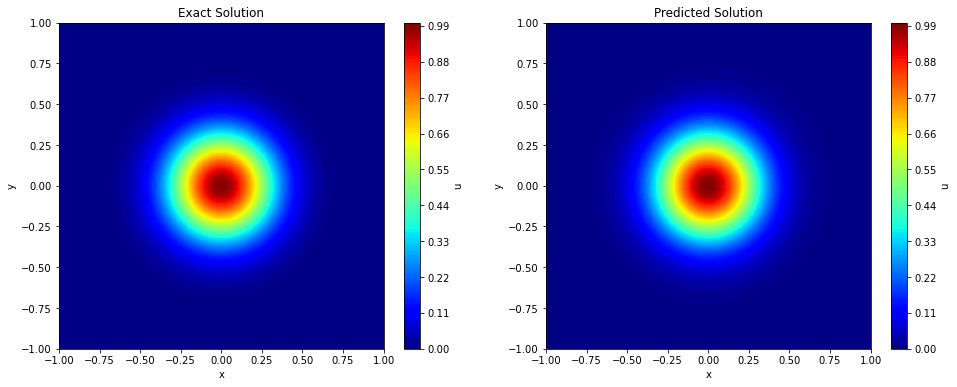

In [20]:

u_ex =u_ex.detach().numpy()

# Calculate errors
relative_error = np.linalg.norm((u_ex - u_pred)) / np.linalg.norm(u_ex)
mse_error = np.mean((u_pred - u_ex)**2)

print(relative_error)
print(mse_error)

# Create the plot

fig, axs = plt.subplots(1, 2, figsize=(16, 6))
contour1 = axs[0].contourf(x.cpu().detach().numpy(), y.cpu().detach().numpy(), u_ex, levels=100, cmap='jet')
fig.colorbar(contour1, ax=axs[0], label='u')
axs[0].set_title('Exact Solution')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')

# Plot the predicted solution
contour2 = axs[1].contourf(x.cpu().detach().numpy(), y.cpu().detach().numpy(), u_pred, levels=100, cmap='jet')
fig.colorbar(contour2, ax=axs[1], label='u')
axs[1].set_title('Predicted Solution')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')

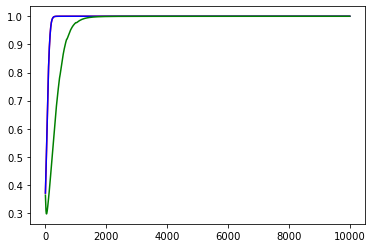

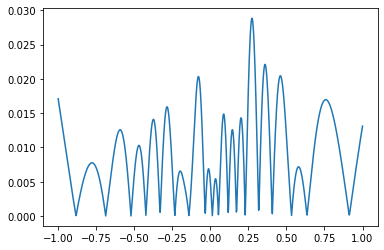

ValueError: x and y must have same first dimension, but have shapes (39,) and (99,)

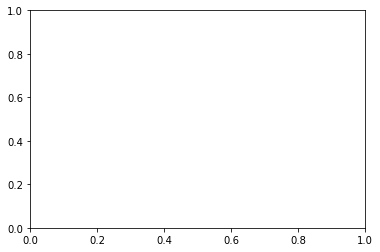

In [8]:
epochs = [i*100 for i in range(2,41)]
x = torch.linspace(-1, 1, 1000).to(device)
y = torch.linspace(-1, 1, 1000).to(device)
risidual = f2(x.unsqueeze(1), y.unsqueeze(1),pinn2)

plt.plot(W_i ,label = 'W_i',color = 'red')
plt.plot(W_bc ,label = 'W_bc',color = 'blue')
plt.plot(W_f ,label = 'W_f',color = 'green')
plt.show()

plt.plot(x.cpu().flatten().detach().numpy(),risidual.cpu().detach().numpy()  )
plt.show()
plt.plot(epochs ,np.log(MSE[2:250])  )
plt.xlabel("epochs")
plt.ylabel("MSE")
plt.show()

plt.plot(epochs ,np.log(L2_ERROR[2:250]) ,color = 'orange' )
plt.xlabel("epochs")
plt.ylabel("L2_error")
plt.show()

plt.plot(epochs ,LOSS[2:] ,color = 'orange' )
plt.xlabel("epochs")
plt.ylabel("LOSS")
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def u_exact(x , y):
    return np.exp(-10*(x**2 + y**2))*100

x= torch.linspace(-1,1,100)
y= torch.linspace(-1,1,100)
x,y = torch.meshgrid(x,y)
u_ex = u_exact(x,y)

u_pred = ui(x.flatten().unsqueeze(1), y.flatten().unsqueeze(1),pinn2)
#inverse scaling on the boundarys
u_pred = u_pred.reshape(100, 100)
u_pred = u_pred.detach().numpy()
print(torch.linalg.norm((u_ex - 100*u_pred) ** 2)/torch.linalg.norm((u_ex ) ** 2))
plt.contourf(x, y, u_ex,levels = 100 , cmap='jet')
plt.colorbar()
plt.show()




plt.contourf(x, y, 100*u_pred,levels = 100 , cmap='jet')
plt.colorbar()
plt.show()